In [6]:
# Libary Imports
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import norm,t

# Local Imports
from utility import histnorm,load_data



In [7]:
# Load Data
df = load_data('DASH_merged.txt')
df.head()

,positive_score_en,negative_score_en,score_en,positive_volume_en,negative_volume_en,volume_ratio_en,total_volume_en,total_volume_non_en,total_volume_global,close,high,low,open,volumefrom,volumeto,logclose,loghigh,loglow,logopen,fluctuation
time,,,,,,,,,,,,,,,,,,,,
2018-01-02 11:00:00,2.040000,1.339500,0.700500,3,1,3.0000,48,3,51,1092.99,1098.78,1089.73,1097.59,973.44,1063595.19,6.996672,7.001956,6.993685,7.000872,-0.004200
2018-01-02 12:00:00,1.750175,1.512967,0.237208,16,3,5.3333,212,30,242,1089.11,1099.60,1085.70,1092.99,465.27,509020.53,6.993116,7.002702,6.989980,6.996672,-0.003556
2018-01-02 13:00:00,1.901171,1.776850,0.124321,38,6,6.3333,226,33,259,1113.63,1115.54,1089.19,1089.28,1576.62,1740882.55,7.015380,7.017094,6.993190,6.993272,0.022108
2018-01-02 14:00:00,2.065209,1.442150,0.623059,32,4,8.0000,255,17,272,1104.40,1117.30,1102.59,1113.25,883.14,980074.94,7.007057,7.018670,7.005417,7.015039,-0.007981
2018-01-02 15:00:00,1.757532,1.685425,0.072107,34,4,8.5000,247,17,264,1100.28,1107.73,1090.27,1104.89,640.29,704188.97,7.003320,7.010068,6.994181,7.007501,-0.004181


In [8]:
# Log Returns
r = df['logclose'].pct_change().dropna()
# r = r.resample('D').sum()


# Rank-frequency Plot

In [22]:
## Estimate emprical CCDF for log returns
# Compute Ranks
r_sorted = r.sort_values(ascending=True)
r_ranks = np.array(range(len(r_sorted)))

# Compute CCDF
N = len(r_sorted)
y1 = 1 - r_ranks/(N+1) 

## Estimate emprical CCDF for log loss
# Compute Ranks
l = -r
l_sorted = l.sort_values(ascending=True)
l_ranks = np.array(range(len(l_sorted)))

# Compute CCDF
N = len(l_sorted)
y2 = 1 - l_ranks/(N+1) 


##  Estimate Gaussian CCDF
# Define point grid between min and max log return
nbins = 100
x = np.linspace(np.min(r),np.max(r),nbins)  

# Compute Gaussian CCDF
mean, std = norm.fit(r)
c = 0.5*(1 - erf((r_sorted-mean)/(std*np.sqrt(2))))

Text(0, 0.5, 'CCDF')

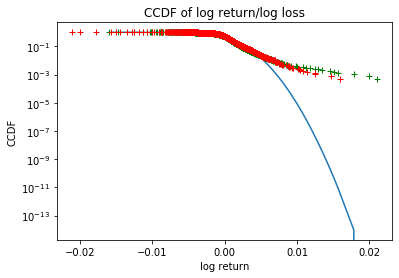

In [23]:
# Plot results
fig,ax = plt.subplots()

ax.semilogy(r_sorted,c,label='Normal')
ax.semilogy(r_sorted,y1,'g+', label='positive returns')
ax.semilogy(l_sorted,y2,'r+', label='negative returns')
ax.set_title('CCDF of log return/log loss')
ax.set_xlabel('log return')
ax.set_ylabel('CCDF')


# Power Law Tail Fit

In [38]:
def power_law_fit(x, tail='right', q=0.1):
    """Function to fit the Power Law Distribution to the right or left tail of returns.

    Args:
        x: Returns.
        q (float):  Define tail as top or bottom q% of returns.
        tail (str): The tail to compute 'right' or 'left'
    Returns:
        alpha (float): The tail exponent.
        x: The tail values.
    """

    # Sort Data
    x = np.sort(x)

    if tail == 'right':
        # Select top q%  
        x = x[round((1-q)*len(x)):] 
    elif tail== 'left':
        # Select bottom q%
        x = x[:round(q*len(x))]

        # Convert negative returns to positive numbers
        x = abs(x)

    # MLE for tail exponent
    N = len(x)
    alpha = N/np.sum(np.log(x/min(x)))     
    return alpha, x 

Right tail exponent: 1.9674990920247644


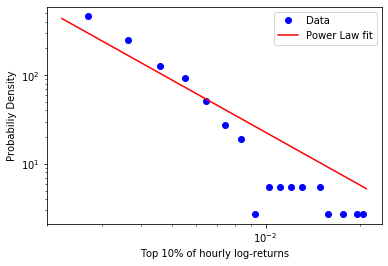

In [39]:
# Fitting the Right Tail of the sample data
alpha_right,right_tail = power_law_fit(r,'right')
print(f'Right tail exponent: {alpha_right}')

# Define Grid
x = np.linspace(min(right_tail),max(right_tail),100)

# Power law Distribution
power_law = ((alpha_right-1)/min(right_tail))*(x/min(right_tail))**(-alpha_right)

# Empirical Distribution
f,bin_centers = histnorm(right_tail,n_bins= 20)

# Plot the Right Tail Fit
fig,ax = plt.subplots()
ax.loglog(bin_centers,f,'bo',label="Data")
ax.loglog(x,power_law,'r',label='Power Law fit')
ax.set_xlabel('Top 10% of hourly log-returns')
ax.set_ylabel('Probabiliy Density')
ax.legend()

Left tail exponent: 2.1198781056928024


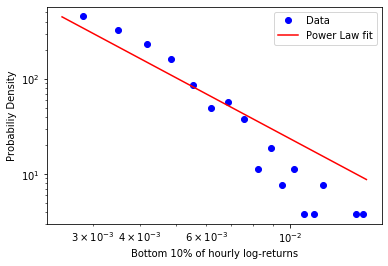

In [40]:
# Fitting the Left Tail of the sample data
alpha_left,left_tail = power_law_fit(r,'left')
print(f'Left tail exponent: {alpha_left}')

# Define Grid
x = np.linspace(min(left_tail),max(left_tail),100)

# Power law Distribution
power_law = ((alpha_left-1)/min(left_tail))*(x/min(left_tail))**(-alpha_left)

# Empirical Distribution
f,bin_centers = histnorm(left_tail,n_bins= 20)

# Plot the Right Tail Fit
fig,ax = plt.subplots()
ax.loglog(bin_centers,f,'bo',label="Data")
ax.loglog(x,power_law,'r',label='Power Law fit')
ax.set_xlabel('Bottom 10% of hourly log-returns')
ax.set_ylabel('Probabiliy Density')
ax.legend()

# Bootstrapping Confidence Interval of Tail Exponent

In [46]:
def bootstrap_tail(x, q=0.1,Nbts=10000,bts=0.8, p=0.9,tail='right'):
    """Function to bootstrap the tail exponent for the right or left tail of returns.

    Args:
        x: Returns.
        Nbts (int):  Number of bootstrap samples.
        bts (float): Fraction of data to be retained in each bootstrap sample.
        p (float): Significance level.
        tail (str): The tail to compute 'right' or 'left'
        q (float): Define tail as top or bottom q% of returns.
    Returns:
        The return value. True for success, False otherwise.

    """

    # Collect bootstrap estimates for tail exponent
    alpha_bts = [] 

    for i in range(Nbts):

        # Random permutation of returns
        x_bts = np.random.permutation(x) 

        # Bootstrapping bts% of returns 
        x_bts = x_bts[0:round(bts*len(x_bts))] 

        # Computing alpha
        result = power_law_fit(x_bts,tail,q)

        alpha_bts.append(result[0])
    CI_left = np.quantile(alpha_bts,(1-p)*0.5)
    CI_right =  np.quantile(alpha_bts, (1+p)*0.5)
    return CI_left, CI_right, alpha_bts

CI_left, CI_right, alpha_bts = bootstrap_tail(r, Nbts=10000,bts=0.8, p=0.9,tail='right')

print(f'Right tail interval at CL: [{CI_left:.2f} ; {CI_right:.2f}]')

CI_left, CI_right, alpha_bts = bootstrap_tail(r, Nbts=10000,bts=0.8, p=0.9,tail='left')

print(f'Left tail interval at CL: [{CI_left:.2f} ; {CI_right:.2f}]')

Right tail interval at CL: [1.89 ; 2.03]
Left tail interval at CL: [2.04 ; 2.20]


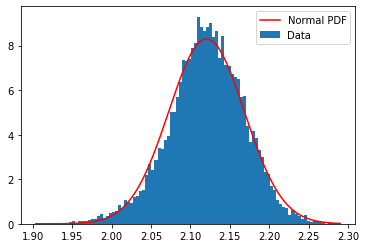

In [47]:
# Fit Normal Distribution for Alpha Values
x = np.linspace(min(alpha_bts),max(alpha_bts),200)
mu,sigma = norm.fit(alpha_bts)

fig,ax = plt.subplots()
ax.hist(alpha_bts,100,density=True,label='Data')
ax.plot(x,norm.pdf(x,loc = mu, scale = sigma),'r',label ='Normal PDF')
ax.legend()

In [ ]:

#Generalized Pareto Distribution
# paramEsts = gpfit(right_tail); % 95% confidence intervals for the parameter estimates.
# kHat      = paramEsts(1);   % Tail index parameter
# sigmaHat  = paramEsts(2);  % Scale parameter

# %GeneralizedExtremeValue
# ExtremeValue = fitdist(right_tail,'GeneralizedExtremeValue');

# %Exponential Distributions
# Exponential = fitdist(right_tail,'Exponential');
% 
# y1 = gppdf(x,kHat,sigmaHat); %Generalized Pareto
# y2 = pdf(ExtremeValue,x); %Generalized Extreme Value 
# y3 = pdf(Exponential,x); %Exponential Distribution

% figure(7)
% loglog(x,h,'ob','MarkerSize',8,'MarkerFaceColor','b')
% hold on
% loglog(x,y1,'r','LineWidth',2)
% set(gca,'FontSize',20)
% title('Right tail Pareto')
% 
% figure(8)
% loglog(x,h,'ob','MarkerSize',8,'MarkerFaceColor','b')
% hold on
% loglog(x,y2,'r','LineWidth',2)
% set(gca,'FontSize',20)
% title('Right tail Extreme Value')
% 
% figure(9)
% loglog(x,h,'ob','MarkerSize',8,'MarkerFaceColor','b')
% hold on
% loglog(x,y3,'r','LineWidth',2)
% set(gca,'FontSize',20)
% title('Right tail Exponential')

%https://www.mathworks.com/help/stats/generalized-pareto-distribution.html


%https://en.wikipedia.org/wiki/Heavy-tailed_distribution
%https://en.wikipedia.org/wiki/Power_law

%% Testing
%One-sample Kolmogorov-Smirnov test

[KST_N,p1] = kstest(r,'CDF',PD_n,'Alpha',0.01)%Testing the Normal Distribution
[KST_T,p2] = kstest(r,'CDF',PD_t,'Alpha',0.01)%Testing the t-student


%[h,p,ksstat,cv] = kstest(r,'CDF',PD_t,'Alpha',0.01) %detailed test of t-student

%Anderson-Darling test
[ADT_N,p] = adtest(r,'Distribution','norm','Alpha',0.01) 



%https://uk.mathworks.com/help/stats/kstest.html
%https://uk.mathworks.com/help/stats/adtest.html

